# Application for the Journal of Open Aviation Science

This document has been published for reproducing the application presented in a software paper dedicated to AeroMAPS, published in [Journal of Open Aviation Science](https://journals.open.tudelft.nl/joas/index). The different assumptions of this prospective scenario are given in the following. 

An illustrative 2% annual air traffic growth is assumed for the different aviation markets, i.e. lower than trend estimates of around 3%. The impact of COVID-19 is modelled assuming that air traffic returns to 2019 levels in 2024. Concerning the aircraft fleet, an accelerated fleet renewal is assumed with the introduction of 20% more efficient aircraft architectures in 2035. A hydrogen-powered aircraft is more specifically considered for short-range. Operational improvements are also included for reducing fuel consumption, but operational strategies for contrail avoidance are not considered here, even though it is a promising approach. Regarding the replacement of kerosene by drop-in fuels (biofuel and electrofuel here), ReFuelEU targets are considered as blending mandates. Different pathways are considered for the production of biofuel and hydrogen. Electricity production is expected to decarbonise rapidly and strongly, so that CO<sub>2</sub> emissions from electricity-based fuels will be lower than those from kerosene by 2035. On the economic side, several assumptions are made such as median fuel costs or a constant electricity price of 80 €/MWh. Moreover, a carbon price trajectory, based on *Alain Quinet, What Value Do We Attach to Climate Action?, 2019*, is implemented in the form of a tax on the emissions of fossil and alternative fuels.

Moreover, in order to carry out a sustainability assessment, some assumptions are required for setting targets for aviation. A climate target of +1.8°C with a 67% chance of success is chosen as well as a moderate use of Carbon Dioxide Removal (CDR) worldwide. Median estimations are considered for biomass and electricity availability. Finally, concerning allocation rules, a grandfathering approach is assumed for climate issues, which means that 2.6% (i.e. aviation's current share of CO<sub>2</sub> emissions) of the world carbon budget is allocated for aviation. For energy resources, an illustrative and arbitrary allocation of 5% is assumed.

## Load and process

In [1]:
%matplotlib widget
import time
import numpy as np
import pandas as pd
from aeromaps.core.process import create_process
from aeromaps.core.models import models_complex
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    Fleet,
    AircraftParameters,
    Aircraft,
)

In [2]:
process = create_process(
    models=models_complex,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)

## Set up variables

### Aviation scenario

In [3]:
# Air traffic evolution

## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [2.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [2.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [2.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [2.0]

In [4]:
# Aircraft fleet

## Initialization
fleet = process.fleet

## Short Range
short_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2030,
    consumption_evolution=-15.0,
    nox_evolution=-75.0,
    soot_evolution=-100.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
)
short_range_aircraft = Aircraft(
    "New Short-range Aircraft - Conventional",
    parameters=short_range_aircraft_params,
    energy_type="DROP_IN_FUEL",
)
fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

## Short Range
short_range_aircraft_2_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=-30.0,
    nox_evolution=-50.0,
    soot_evolution=-50.0,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    hybridization_factor=0.5,
)
short_range_aircraft_2 = Aircraft(
    "New Short-range Aircraft - Hybrid-electric",
    parameters=short_range_aircraft_2_params,
    energy_type="HYBRID_ELECTRIC",
)
fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft_2)

## Short Range
short_range_aircraft_3_params = AircraftParameters(
    entry_into_service_year=2045,
    consumption_evolution=0.0,
    nox_evolution=-100.0,
    soot_evolution=-100.0,
    doc_non_energy_evolution=20.0,
    cruise_altitude=12000.0,
)
short_range_aircraft_3 = Aircraft(
    "New Short-range Aircraft - Electric",
    parameters=short_range_aircraft_3_params,
    energy_type="ELECTRIC",
)
fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft_3)

## Medium Range
medium_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
)
medium_range_aircraft = Aircraft(
    "New Medium-range Aircraft", parameters=medium_range_aircraft_params, energy_type="HYDROGEN"
)
fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

## Long Range
long_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
)
long_range_aircraft = Aircraft(
    "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)

## Fleet renewal
fleet.categories["Short Range"].parameters.life = 20
fleet.categories["Medium Range"].parameters.life = 20
fleet.categories["Long Range"].parameters.life = 20

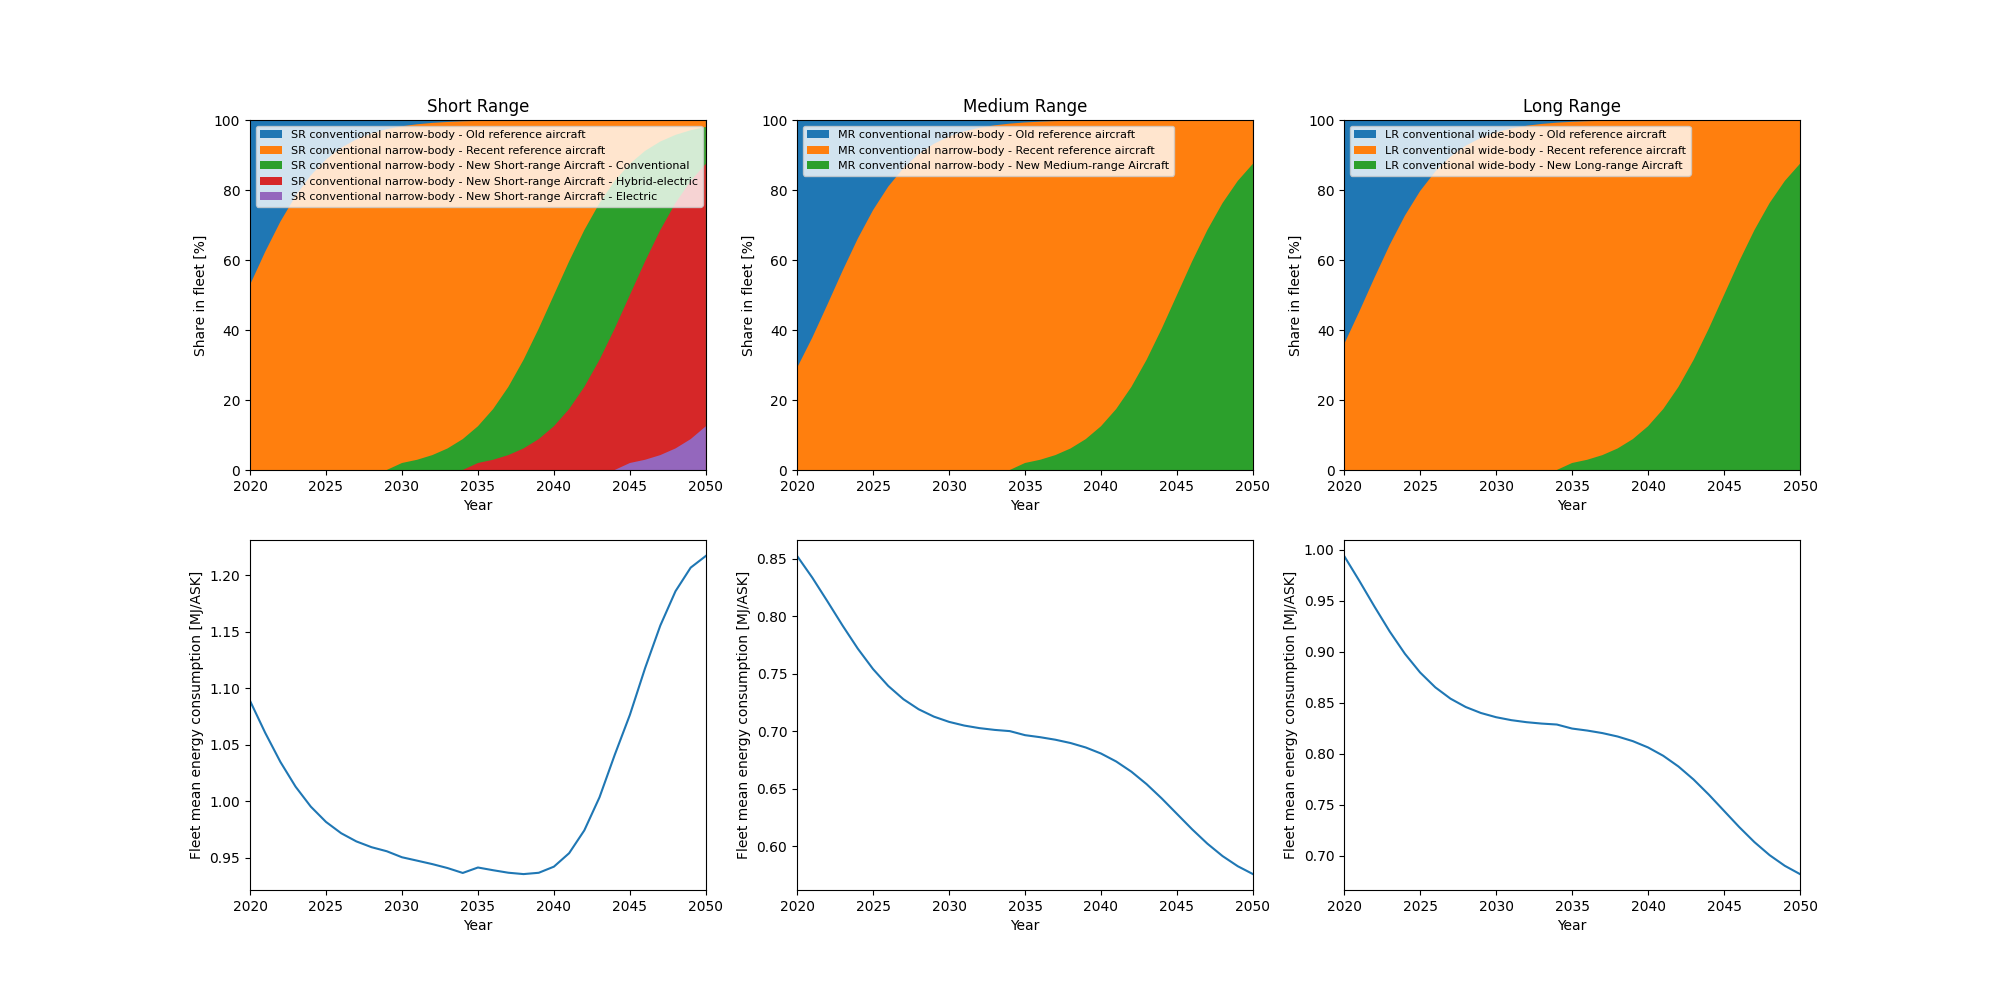

In [5]:
fleet_model = process.fleet_model
fleet_model.compute()
fleet_model.plot()

In [6]:
fleet_model.df.to_csv("fleet.csv")

In [7]:
# Aircraft fleet and operation evolution - Aircraft load factor

## Aircraft load factor in 2050 [%]
process.parameters.load_factor_end_year = 89  # 2019 value: 82.399312

In [8]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

In [9]:
# Aircraft energy - Introduction of alternative drop-in fuels

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_share_reference_years_values = [0.0, 4.8, 24.0, 35.0]
process.parameters.electrofuel_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electrofuel_share_reference_years_values = [0.0, 1.2, 10.0, 35.0]

In [10]:
# Various environmental settings

## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_hefa_fog_share_reference_years_values = [100, 0.7, 0.7, 0.7]
process.parameters.biofuel_hefa_others_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_hefa_others_share_reference_years_values = [0.0, 3.8, 3.8, 3.8]
process.parameters.biofuel_ft_others_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_ft_others_share_reference_years_values = [0.0, 76.3, 76.3, 76.3]
process.parameters.biofuel_ft_msw_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_ft_msw_share_reference_years_values = [0.0, 7.4, 7.4, 7.4]

## Emission factors for electricity (2019 value: 429 gCO2/kWh)
process.parameters.electricity_emission_factor_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electricity_emission_factor_reference_years_values = [429.0, 180.0, 75.0, 30.0]

## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
process.parameters.hydrogen_electrolysis_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.hydrogen_electrolysis_share_reference_years_values = [2, 50, 100, 100]
process.parameters.hydrogen_gas_ccs_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0, 0, 0, 0]
process.parameters.hydrogen_coal_ccs_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0, 0, 0, 0]
process.parameters.hydrogen_gas_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.hydrogen_gas_share_reference_years_values = [71, 50, 0, 0]

In [11]:
# Cost parameters

## Carbon tax
process.parameters.carbon_tax_reference_years = [2020, 2030, 2040, 2050]
process.parameters.carbon_tax_reference_years_values = [
    5,
    250,
    500,
    775,
]  # 2020 value differs from the value of Quinet (54 €/tCO2)

### Sustainability assessment

In [12]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

## Available energy resources in 2050 [EJ]
process.parameters.waste_biomass = 12
process.parameters.crops_biomass = 63
process.parameters.forest_residues_biomass = 17
process.parameters.agricultural_residues_biomass = 57
process.parameters.algae_biomass = 15
process.parameters.available_electricity = 200.0

In [13]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 5.0
process.parameters.aviation_electricity_allocated_share = 5.0

## Compute

In [14]:
t1 = time.time()
process.compute()
t2 = time.time()
print("Computation time:", np.round(t2 - t1, 2), "s")

Computation time: 1.03 s


## Results

### Excel data

In [15]:
process.write_excel(file_name="aeromaps_data.xlsx")

### Main results

In [16]:
print(
    "CO2 emissions in 2050:",
    round(process.data["climate_outputs"]["co2_emissions"][2050], 0),
    "MtCO2, i.e. an evolution of:",
    round(
        (
            (
                process.data["climate_outputs"]["co2_emissions"][2050]
                / process.data["climate_outputs"]["co2_emissions"][2019]
            )
            - 1
        )
        * 100,
        0,
    ),
    "% compared to 2019",
)
print(
    "CO2 emissions per RPK in 2050:",
    round(process.data["vector_outputs"]["co2_emissions_per_rpk"][2050], 0),
    "gCO2/RPK, i.e. an evolution of:",
    round(
        (
            (
                process.data["vector_outputs"]["co2_emissions_per_rpk"][2050]
                / process.data["vector_outputs"]["co2_emissions_per_rpk"][2019]
            )
            - 1
        )
        * 100,
        0,
    ),
    "% compared to 2019",
)
print(
    "Temperature increase due to aviation in 2050:",
    round(process.data["climate_outputs"]["temperature_increase_from_aviation"][2050], 3),
    "°C, i.e. an evolution of:",
    round(
        (
            (
                process.data["climate_outputs"]["temperature_increase_from_aviation"][2050]
                / process.data["climate_outputs"]["temperature_increase_from_aviation"][2019]
            )
            - 1
        )
        * 100,
        0,
    ),
    "% compared to 2019",
)
print(
    "Total Direct Operating Cost, including carbon tax in 2050:",
    round(process.data["vector_outputs"]["doc_total_per_ask_mean"][2050], 3),
    "€/ASK, i.e. an evolution of:",
    round(
        (
            (
                process.data["vector_outputs"]["doc_total_per_ask_mean"][2050]
                / process.data["vector_outputs"]["doc_total_per_ask_mean"][2019]
            )
            - 1
        )
        * 100,
        0,
    ),
    "% compared to 2019",
)

CO2 emissions in 2050: 341.0 MtCO2, i.e. an evolution of: -70.0 % compared to 2019
CO2 emissions per RPK in 2050: 20.0 gCO2/RPK, i.e. an evolution of: -82.0 % compared to 2019
Temperature increase due to aviation in 2050: 0.073 °C, i.e. an evolution of: 82.0 % compared to 2019
Total Direct Operating Cost, including carbon tax in 2050: 0.065 €/ASK, i.e. an evolution of: 50.0 % compared to 2019


### Plots

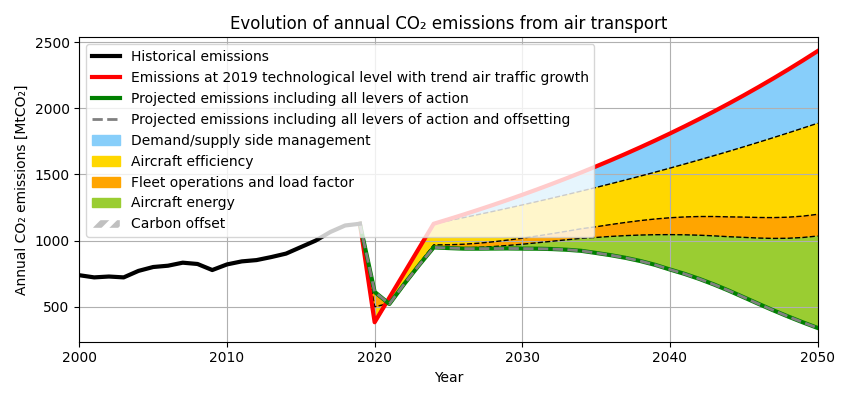

In [17]:
process.plot("air_transport_co2_emissions")

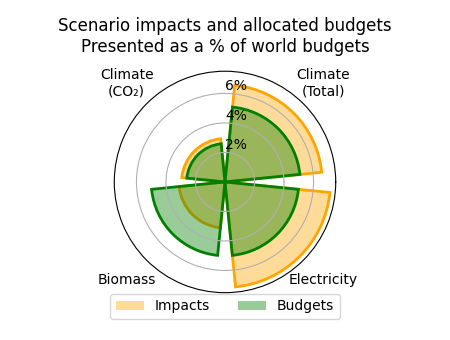

In [18]:
process.plot("multidisciplinary_assessment")

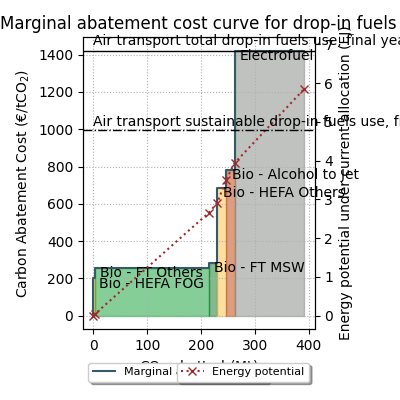

In [19]:
process.plot("drop_in_macc_curve")

## Sensitivity study

In [20]:
consumption_evolution_min = 10 # %
consumption_evolution_max = -15 # %

electrolysis_efficiency_min = 0.5
electrolysis_efficiency_max = 0.7

liquefaction_efficiency_min = 0.7
liquefaction_efficiency_max = 0.9


# Hydrogen
process.fleet.categories["Short Range"].subcategories[0].aircraft[2].parameters.entry_into_service_year = 2070
process.fleet.categories["Short Range"].subcategories[0].aircraft[1].energy_type = "HYDROGEN"

# Hybrid-electric
# process.fleet.categories["Short Range"].subcategories[0].aircraft[2].parameters.entry_into_service_year = 2070
# process.fleet.categories["Short Range"].subcategories[0].aircraft[1].energy_type = "HYBRID_ELECTRIC"

# Electric
# process.fleet.categories["Short Range"].subcategories[0].aircraft[2].parameters.entry_into_service_year = 2070
# process.fleet.categories["Short Range"].subcategories[0].aircraft[1].energy_type = "ELECTRIC"

In [21]:
results = []

for consumption_evolution in np.linspace(consumption_evolution_min, consumption_evolution_max, num=5):
    process.fleet.categories["Short Range"].subcategories[0].aircraft[0].parameters.consumption_evolution = consumption_evolution
    
    for electrolysis_efficiency in np.linspace(electrolysis_efficiency_min, electrolysis_efficiency_max, num=5):
    
        process.parameters.electrolysis_efficiency_reference_years_values = [electrolysis_efficiency]
        
        for liquefaction_efficiency in np.linspace(liquefaction_efficiency_min, liquefaction_efficiency_max, num=5): 
            process.parameters.liquefaction_efficiency_reference_years_values = [liquefaction_efficiency]

            process.compute()
            co2_emissions_2050 = process.data["climate_outputs"]["co2_emissions"][2050]
            electricity_consumption_2050 = process.data["vector_outputs"]["electricity_consumption"][2050]
            biomass_consumption_2050 = process.data["vector_outputs"]["biomass_consumption"][2050]

            results.append({"consumption_evolution": consumption_evolution,
                            "electrolysis_efficiency": electrolysis_efficiency,
                            "liquefaction_efficiency": liquefaction_efficiency,
                            "co2_emissions_2050": co2_emissions_2050,
                            "electricity_consumption_2050": electricity_consumption_2050,
                            "biomass_consumption_2050": biomass_consumption_2050,
                           })
    
df_results = pd.DataFrame(results)

In [22]:
df_results

,consumption_evolution,electrolysis_efficiency,liquefaction_efficiency,co2_emissions_2050,electricity_consumption_2050,biomass_consumption_2050
0,10.00,0.50,0.70,374.106019,22.471672,4.316953
1,10.00,0.50,0.75,364.969050,21.375236,4.316953
2,10.00,0.50,0.80,356.974203,20.415854,4.316953
3,10.00,0.50,0.85,349.919925,19.569341,4.316953
4,10.00,0.50,0.90,343.649457,18.816885,4.316953
5,10.00,0.55,0.70,357.082025,20.428793,4.316953
6,10.00,0.55,0.75,348.775690,19.432033,4.316953
7,10.00,0.55,0.80,341.507646,18.559868,4.316953
8,10.00,0.55,0.85,335.094667,17.790310,4.316953
9,10.00,0.55,0.90,329.394241,17.106259,4.316953
